In [1]:
from deepxde.geometry.geometry_1d import Interval
from deepxde.geometry.geometry_2d import (
    Disk, Ellipse, Polygon, Rectangle, StarShaped, Triangle
)
from deepxde.geometry.geometry_3d import Cuboid, Sphere
from deepxde.geometry.geometry_nd import Hypercube, Hypersphere
from deepxde.geometry.timedomain  import GeometryXTime, TimeDomain

import deepxde as dde
dde.backend.set_default_backend("tensorflow")

import numpy as np

2024-05-21 21:59:59.093673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [2]:
Re = 100

def navier_stocks(x, u):
    u_vel, v_vel, p = u[:, 0:1], u[:, 1:2], u[:, 2:3]

    u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_t = dde.grad.jacobian(u, x, i=0, j=2)
    u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)

    v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_t = dde.grad.jacobian(u, x, i=1, j=2)
    v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(u, x, i=2, j=0)
    p_y = dde.grad.jacobian(u, x, i=2, j=1)

    momentum_x = (
        u_vel_t
        + (u_vel * u_vel_x + v_vel * u_vel_y)
        + p_x
        - 1 / Re * (u_vel_xx + u_vel_yy)
    )
    momentum_y = (
        v_vel_t
        + (u_vel * v_vel_x + v_vel * v_vel_y)
        + p_y
        - 1 / Re * (v_vel_xx + v_vel_yy)
    )
    continuity = u_vel_x + v_vel_y
    return [momentum_x, momentum_y, continuity]


In [3]:
base_domain = Rectangle(xmin=[0, 0], xmax=[3, 1])
# barrier_domain = Ellipse(
#     center=[0.5, 0.5], semimajor=0.1, semiminor=0.1
#     )
barrier_domain = Rectangle(xmin=[0.8, 0.4], xmax=[1, 0.6])
space_domain = base_domain - barrier_domain

time_domain = dde.geometry.TimeDomain(0, 1)

domain = dde.geometry.GeometryXTime(space_domain, time_domain)

boundary_condition_inlet = dde.DirichletBC(
    domain, lambda x: 0.3,
    lambda x, on_boundary: 
    np.isclose(x[0], 0.),
    component=0
)
boundary_condition_outlet = dde.NeumannBC(
    domain, lambda x: 0, 
    lambda x, on_boundary: 
    np.isclose(x[0], 3.),
    component=2
)
boundary_condition_u_top = dde.DirichletBC(
    domain, lambda x: 0,
    lambda x, on_boundary: 
    np.isclose(x[1], 0.),
    component=0
)
boundary_condition_u_bot = dde.DirichletBC(
    domain, lambda x: 0,
    lambda x, on_boundary: 
    np.isclose(x[1], 1.),
    component=0
)
boundary_condition_v_top = dde.DirichletBC(
    domain, lambda x: 0,
    lambda x, on_boundary: 
    np.isclose(x[1], 0.),
    component=1
)
boundary_condition_v_bot = dde.DirichletBC(
    domain, lambda x: 0,
    lambda x, on_boundary: 
    np.isclose(x[1], 1.),
    component=1
)
barrier_condition_u = dde.DirichletBC(
    domain, lambda x: 0, 
    lambda x, on_boundary: barrier_domain.inside(x[0:2]),
    component=0
)
barrier_condition_v = dde.DirichletBC(
    domain, lambda x: 0, 
    lambda x, on_boundary: barrier_domain.inside(x[0:2]),
    component=1
)

initial_condition_u = dde.IC(
    domain, lambda x: 0,
    lambda x, on_initial: on_initial,
    component=0
)
initial_condition_v = dde.IC(
    domain, lambda x: 0,
    lambda x, on_initial: on_initial, 
    component=1
)

In [4]:
data = dde.data.TimePDE(
    domain,
    navier_stocks,
    [
        boundary_condition_u_top,
        boundary_condition_u_bot,
        boundary_condition_v_top,
        boundary_condition_v_bot,
        initial_condition_u,
        initial_condition_v,
        barrier_condition_u,
        barrier_condition_v,
        boundary_condition_inlet,
        boundary_condition_outlet
    ],
    num_domain=5000,
    num_boundary=500,
    num_initial=500,
    num_test=1000,
)

net = dde.nn.FNN([3] + 4 * [50] + [3], "tanh", "Glorot normal")

model = dde.Model(data, net)  

model.compile("adam", lr=1e-3, loss_weights=[1, 1, 1, 1, 1, 1, 1, 1, 1, 100, 100, 1, 1])


Compiling model...
'compile' took 0.002890 s



In [5]:
losshistory, train_state = model.train(iterations=3000, display_every=1)

Training model...



/home/ygrik/miniconda3/envs/pinn-env/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e58e550>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e58e550>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e58e550>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7a7c2e58e940>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e58e940>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e58e940>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7a7c2e58ed30>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e58ed30>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e58ed30>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7a7c2e592160>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e592160>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e592160>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7a7c2e592b80>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e592b80>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e592b80>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7a7c2e592e50>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e592e50>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e592e50>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7a7c2e592550>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e592550>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e592550>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7a7c2e592940>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e592940>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e592940>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7a7c2e5ebd30>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e5ebd30>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e5ebd30>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7a7c2e58e160>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e58e160>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7a7c2e58e160>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [6.66e-02, 4.43e-03, 9.99e-03, 9.75e-02, 5.95e-02, 6.05e-04, 9.31e-02, 1.37e-01, 2.36e-02, 1.47e+00, 2.78e+00, 2.90e-02, 4.14e-04]    [6.47e-02, 3.59e-03, 8.31e-03, 9.75e-02, 5.95e-02, 6.05e-04, 9.31e-02, 1.37e-01, 2.36e-02, 1.47e+00, 2.78e+00, 2.90e-02, 4.14e-04]    []  
1         [3.35e-02, 1.40e-02, 5.36e-03, 6.71e-02, 3.74e-02, 2.00e-02, 1.65e-02, 8.75e-02, 9.43e-03, 8.30e-01, 8.63e-02, 3.

In [6]:

# model.compile("L-BFGS")
# losshistory, train_state = model.train(iterations=4000, display_every=1)
# model.restore("model/good_model.ckpt-43904.ckpt", verbose=1)
# losshistory, train_state = model.train(iterations=1, model_restore_path="model/good_model.ckpt-43904.ckpt")

In [7]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

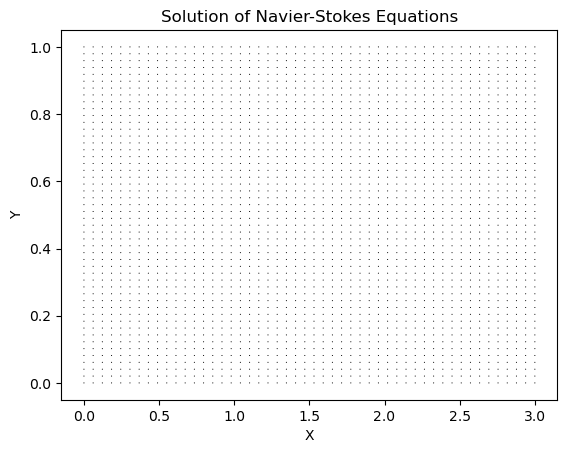

In [8]:
shape = (50, 50)
x, y = np.meshgrid(np.linspace(0, 3, shape[0]), np.linspace(0, 1, shape[1]))
X = np.vstack((np.ravel(x), np.ravel(y))).T

# Time parameters
t_values = np.linspace(0, 1, 120)  # 60 frames for the animation

fig = plt.figure()
ax : plt.Axes = fig.add_subplot(111)

# Initialize quiver plot
quiver = ax.quiver(x, y, np.zeros(x.size), np.zeros(y.size), scale=0.01)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Solution of Navier-Stokes Equations')


def update(frame):
    t = t_values[frame]
    t_array = np.full((shape[0] * shape[1], 1), t)
    X_t = np.hstack((X, t_array))

    output = model.predict(X_t)
    u_pred = output[:, 0].reshape(x.size)
    v_pred = output[:, 1].reshape(y.size)
    quiver.set_UVC(u_pred / 6, v_pred / 6)
    ax.set_title(f'Solution at t = {t:.2f}')
    return quiver,

In [9]:

# ani = FuncAnimation(fig, update, frames=len(t_values), blit=False)
# ani.save("cube_model.gif", writer="imagemagick", fps=10)


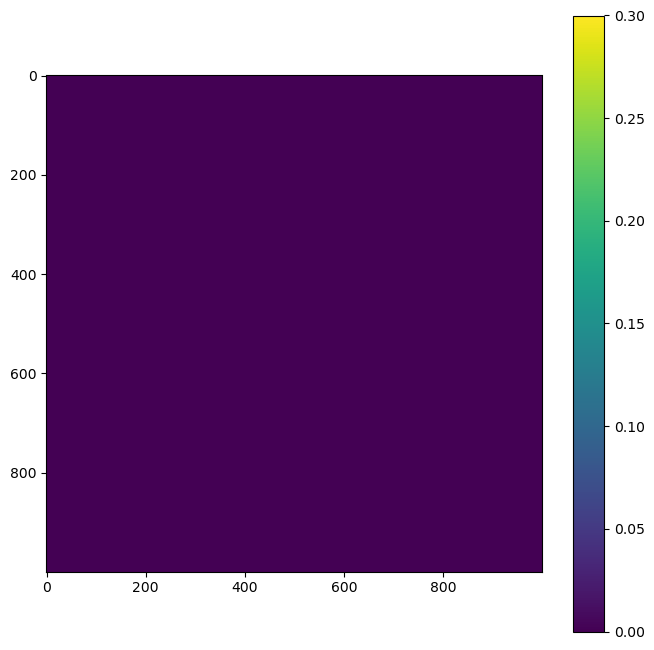

In [10]:

# Создать фигуру и оси
fig, ax = plt.subplots(figsize=(8, 8))

shape = (1000, 1000)

x, y = np.meshgrid(np.linspace(0, 1, shape[0]), np.linspace(0, 1, shape[1]))
X = np.vstack((np.ravel(x), np.ravel(y))).T

# Time parameters
t_values = np.linspace(0, 1, 120)  # 60 frames for the animation



im = ax.imshow(np.zeros(shape), cmap='viridis', vmin=0, vmax=0.3)
plt.colorbar(im)

# ax.title('Хитмап модуля скорости')
# ax.xlabel('X')
# ax.ylabel('Y')

def animate(frame):
    t = t_values[frame]
    t_array = np.full((shape[0] * shape[1], 1), t)
    X_t = np.hstack((X, t_array))

    output = model.predict(X_t)
    u_pred = output[:, 0].reshape(x.size)
    v_pred = output[:, 1].reshape(y.size)
    
    speed = np.sqrt(u_pred**2 + v_pred**2).reshape(shape)
    
    im.set_data(speed)
    ax.set_title(f'Solution at t = {t:.2f}')
    return [im]


In [11]:
ani = FuncAnimation(fig, animate, frames=len(t_values), interval=50, blit=True)
ani.save("cube_model.gif", writer="imagemagick", fps=10)